In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
   
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1l1WBEb2GvJo8fXALiDwNrdy9RkM30EVL'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_img.tgz')
file_id = '15PyUo6bpwNj8FDxFu94-VqZzULEl4Llr'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_img.tgz')
file_id = '1ypv3os2LLfQMnjMHemRsC-9JViiAW6PU'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.csv')


In [ ]:
import tarfile

with tarfile.open('train_img.tgz') as tf:
  tf.extractall()

with tarfile.open('test_img.tgz') as tf:
  tf.extractall()

In [ ]:
def load_data(img_path, label_path):
    train_image = sorted(os.listdir(img_path))
    train_image = ['./train_img/' + i for i in train_image]
    train_label = pd.read_csv(label_path)
    train_label = train_label['label'].values.tolist()
    
    train_data = list(zip(train_image, train_label))
    random.shuffle(train_data)
    
    train_set = train_data[:26000]
    val_set = train_data[26000:]
    
    return train_data, val_set

In [ ]:
class cnn_dataset(Dataset):
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0])
        img = self.transform(img)
        label = self.data[idx][1]
        return img, label

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),     
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),            
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            
        )
        self.fc = nn.Sequential(
            nn.Linear(128*3*3, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.Linear(512, 7),
        )

    def forward(self, x):
        #image size (48,48)
        x = self.conv1(x) #(24,24)
        x = self.conv2(x) #(12,12)
        x = self.conv3(x) #(6,6)
        x = self.conv4(x) #(3,3)
        x = x.view(-1, 3*3*128)
        x = self.fc(x)
        return x

In [ ]:
if __name__ == '__main__':    
    
    use_gpu = torch.cuda.is_available()

    train_set, val_set = load_data('train_img', 'train.csv')
    
    transform = transforms.Compose([transforms.ToTensor()])
  #  transfrom = torch.FloatTensor()
    
    train_dataset = cnn_dataset(train_set, transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    val_dataset = cnn_dataset(val_set, transform)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    
    model = Net()
    if use_gpu:
        model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    loss_fn = nn.CrossEntropyLoss()
    
    num_epoch = 14
    for epoch in range(num_epoch):
        model.train()
        train_loss = []
        train_acc = []
        for idx, (img, label) in enumerate(train_loader):
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            optimizer.zero_grad()
            output = model(img)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            predict = torch.max(output, 1)[1]
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
        print("Epoch: {}, train Loss: {:.4f}, train Acc: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
        
        model.eval()
        with torch.no_grad():
            valid_loss = []
            valid_acc = []
            for idx, (img, label) in enumerate(val_loader):
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()              
                output = model(img)
                loss = loss_fn(output, label)
                predict = torch.max(output, 1)[1]
                acc = np.mean((label == predict).cpu().numpy())
                valid_loss.append(loss.item())
                valid_acc.append(acc)
            print("Epoch: {}, valid Loss: {:.4f}, valid Acc: {:.4f}".format(epoch + 1, np.mean(valid_loss), np.mean(valid_acc)))
        
        if np.mean(train_acc) > 0.9:
            checkpoint_path = 'model_{}.pkl'.format(epoch+1) 
            torch.save(model.state_dict(), checkpoint_path)
            print('model saved to %s' % checkpoint_path)

Epoch: 1, train Loss: 1.5787, train Acc: 0.3863
Epoch: 1, valid Loss: 1.2766, valid Acc: 0.5014
Epoch: 2, train Loss: 1.2630, train Acc: 0.5192
Epoch: 2, valid Loss: 1.1329, valid Acc: 0.5588
Epoch: 3, train Loss: 1.1340, train Acc: 0.5701
Epoch: 3, valid Loss: 0.9376, valid Acc: 0.6456
Epoch: 4, train Loss: 1.0171, train Acc: 0.6173
Epoch: 4, valid Loss: 0.9152, valid Acc: 0.6645
Epoch: 5, train Loss: 0.9085, train Acc: 0.6576
Epoch: 5, valid Loss: 0.7597, valid Acc: 0.7205
Epoch: 6, train Loss: 0.7935, train Acc: 0.7043
Epoch: 6, valid Loss: 0.5827, valid Acc: 0.7854
Epoch: 7, train Loss: 0.6594, train Acc: 0.7554
Epoch: 7, valid Loss: 0.4332, valid Acc: 0.8516
Epoch: 8, train Loss: 0.5399, train Acc: 0.7993
Epoch: 8, valid Loss: 0.5642, valid Acc: 0.7983
Epoch: 9, train Loss: 0.4348, train Acc: 0.8425
Epoch: 9, valid Loss: 0.3556, valid Acc: 0.8665
Epoch: 10, train Loss: 0.3380, train Acc: 0.8768
Epoch: 10, valid Loss: 0.2374, valid Acc: 0.9193
Epoch: 11, train Loss: 0.2750, train A

In [ ]:
test_img = sorted(os.listdir('./test_img'))
test_img = ['./test_img/' + i for i in test_img]
test_label = np.full(len(test_img),1)
test_data = list(zip(test_img, test_label))
test_data = cnn_dataset(test_data, transform)
test_set = DataLoader(test_data, batch_size=128, shuffle=False)
predict_value = []
for img, _ in test_set: 
    if use_gpu:
        img = img.cuda()
        _ = _.cuda()   
    output = model(img)
    predict_value += (torch.max(output, 1)[1]).tolist()
submission = pd.DataFrame()
submission['id'] = np.arange(len(test_img))
submission['label'] = predict_value
submission.to_csv('predict.csv', index = False)

In [ ]:
from google.colab import files
files.download('predict.csv')

In [ ]:
from sklearn.metrics import confusion_matrix

train_img = sorted(os.listdir('./train_img'))
train_img = ['./train_img/' + i for i in train_img]
train_label = pd.read_csv('train.csv')['label'].values.tolist() 
train_data = list(zip(train_img, train_label))
train_data = cnn_dataset(train_data, transform)
train_set = DataLoader(train_data, batch_size=128, shuffle=False)
predict_value = []
for img, _ in train_set: 
    if use_gpu:
        img = img.cuda()
        _ = _.cuda()   
    output = model(img)
    predict_value += (torch.max(output, 1)[1]).tolist()


array([[3926,   11,   33,   18,   39,    7,   90],
       [   0,  424,    1,    0,    1,    1,    0],
       [  53,    9, 4020,   21,   78,  110,  102],
       [   4,    1,    2, 7178,    0,   28,   32],
       [  41,    1,   69,   40, 4678,    5,  167],
       [   7,    1,   16,    9,    4, 3021,   21],
       [  10,    0,    4,   18,   14,    0, 4573]])

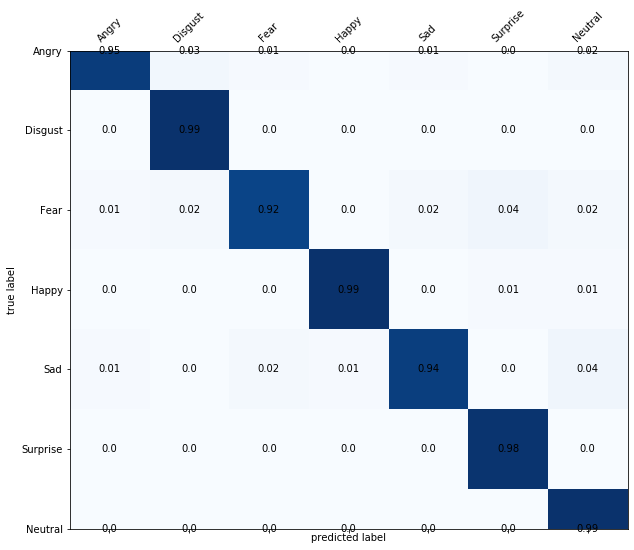

In [ ]:

confmat = confusion_matrix(predict_value, train_label)
confmat = np.around(confmat / confmat.sum(axis=1), 2)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=3)
face = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')

plt.xlabel('predicted label')
plt.xticks([0,1,2,3,4,5,6], labels = face ,rotation = 45)        
plt.ylabel('true label')
plt.yticks([0,1,2,3,4,5,6], labels = face)
plt.show()


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),     
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),            
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),          
        )        

        self.fc = nn.Sequential(
            nn.Linear(3*3*512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 7)
        )            
 

    def forward(self, x):
        #image size (48,48)
        x = self.conv1(x) #(24,24)
        x = self.conv2(x) #(12,12)
        x = self.conv3(x) #(6,6)
        x = self.conv4(x)
        x = x.view(-1, 3*3*512)
        x = self.fc(x)
        return x

In [ ]:
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
model = Resnet18()
backprop = Backprop(model)
inputimg = apply_transforms(train_data.__getitem__(0)[0])
#transforms.Grayscale(inputimg)
gradient = backprop.calculate_gradients(inputimg, 7)

max_gradient = backprop.calculate_gradients(inputimg, 7, take_max=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.4MB/s]
/usr/local/lib/python3.6/dist-packages/flashtorch/saliency/backprop.py:111: UserWarning: The predicted class index 2 does notequal the target class index 7. Calculatingthe gradient w.r.t. the predicted class.
  'the gradient w.r.t. the predicted class.'


In [ ]:
train_set, val_set = load_data('train_img', 'train.csv')
transform = transforms.Compose([transforms.ToTensor()])
train_data = cnn_dataset(train_set, transform)
#inputimg = apply_transforms(train_data.__getitem__(0)[0])
#transforms.Grayscale(inputimg)
#inputimg.shape

In [ ]:
import torchvision.models as models
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.resnet = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])
        self.fc = nn.Linear(512,7)
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, 1*1*512)
        x = self.fc(x)
        
        return x

/usr/local/lib/python3.6/dist-packages/flashtorch/saliency/backprop.py:111: UserWarning: The predicted class index 2 does notequal the target class index 7. Calculatingthe gradient w.r.t. the predicted class.
  'the gradient w.r.t. the predicted class.'


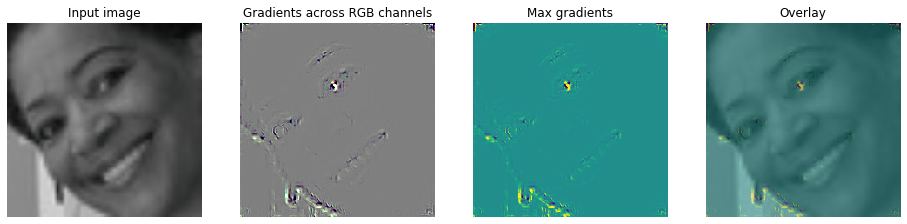

In [ ]:
backprop.visualize(inputimg, 7, guided=True, use_gpu=True)

In [ ]:
model14 = Net()
model14.load_state_dict(torch.load('model_14.pkl'))
model14.cuda()
model14.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, ker

In [ ]:
use_gpu = torch.cuda.is_available()
test_img = sorted(os.listdir('./test_img'))
test_img = ['./test_img/' + i for i in test_img]
test_label = np.full(len(test_img),1)
test_data = list(zip(test_img, test_label))
test_data = cnn_dataset(test_data, transform)
test_set = DataLoader(test_data, batch_size=128, shuffle=False)
predict_value = []
for img, _ in test_set: 
    if use_gpu:
        img = img.cuda()
        _ = _.cuda()   
    output = model14(img)
    predict_value += (torch.max(output, 1)[1]).tolist()
submission = pd.DataFrame()
submission['id'] = np.arange(len(test_img))
submission['label'] = predict_value
submission.to_csv('predict.csv', index = False)